# <font size="20"> <center> **RateABook**
# <br><br>
# <font size="5"> <center> **HIT**<br>
# <center>**“Introduction to data science” final project**<br><br>
# <center>**By Tal Shamli and Eli Shulman**
    
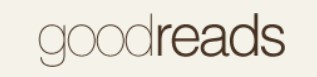

### [Abstract](#Abstract)

### [Imports](#Imports)

### [Obtaining data](#Obtainingdata)
- [Scraping GoodReads](#ScrapingGoodReads)

### [Data handling](#Datahandling)
- [Extracting numeric data](#Extractingnumericdata)
- [Handeling missing values](#Handelingmissingvalues)
- [Handeling duplications](#Handelingduplications)
- [Dealing with outliers](#Dealingwithoutliers)

### [EDA](#EDA)
- [Corolation matrix](#Corolationmatrix)
- [Ploting categorical columns](#Plotingcategoricalcolumns)
- [Ploting numeric columns](#Plotingnumericcolumns)
- [Corolation matrix](#Corolationmatrix)

### [Machine Learning](#MachineLearning)
- [Pre-Processesing](#Pre-Processesing)
- [First model](#Firstmodel)
- [Feature Engineering](#FeatureEngineering)
- [Second model](#Secondmodel)

### [Final Test](#FinalTest)

### [Conclusions](#Conclusions)

# Abstract

### Can you predict the rating of a book based on other features ?

What gives the book its rating ?  What affects its rating ?  Is this the amount of reviewers ?  The number of voters ?         Or even the length of the book or year of publication, etc?
In this project we will try to answer this question by aquiring data on around 28,000 books form the website "GoodReads" and using Machine Learning models to try and predict the rating of a book.

# Imports

In [1]:
import pandas as pd
import numpy as np
import time
import requests
import json
import csv


from selenium import webdriver 
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service


import re


import plotly.express as px
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline



import sklearn
from sklearn import  linear_model
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


# <a class="anchor" id="dataAcquisition"></a> Obtaining data
 
 **sources/credits:**
- https://selenium-python.readthedocs.io/index.html
- https://www.geeksforgeeks.org/how-to-convert-python-dictionary-to-json/
- https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
- https://stackoverflow.com/questions/68412155/selenium-how-to-fill-a-value-and-click-a-button
- https://www.thepythoncode.com/article/automate-login-to-websites-using-selenium-in-python

### Scraping GoodReads
In this part of the project we used selenium to crawl through https://www.goodreads.com/ scrape data regarding books

First, we need to get the links for all the genres :

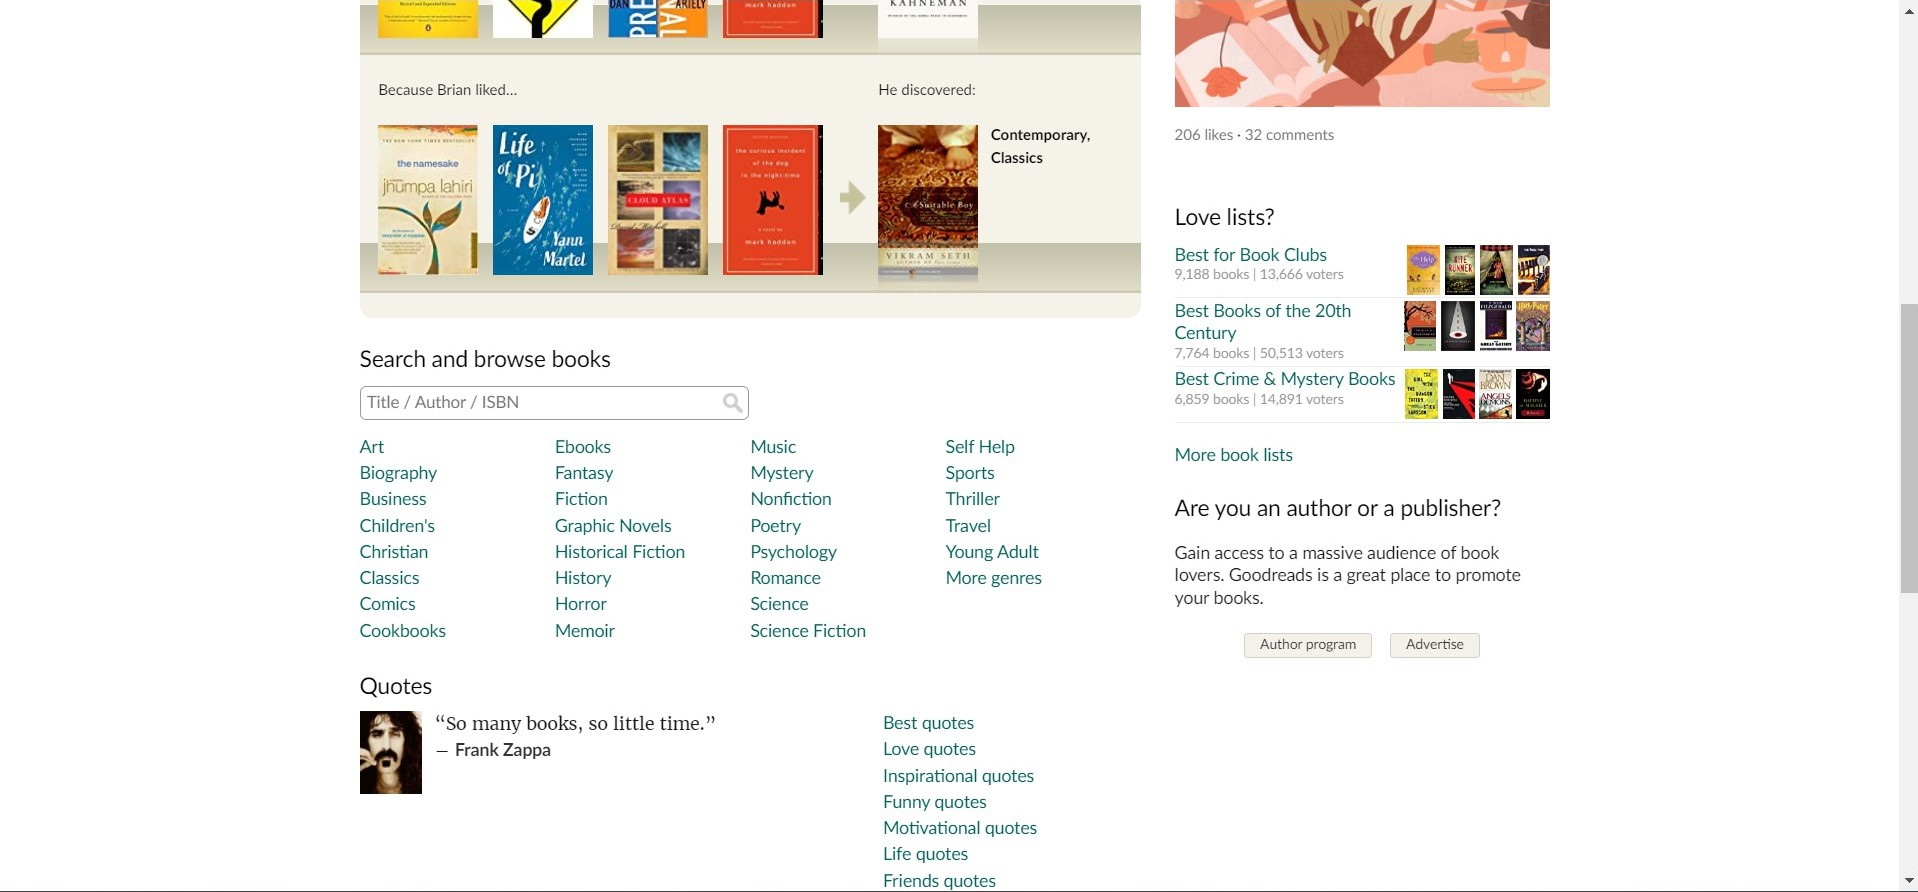

We noticed that we dont have a next button unless we log in :

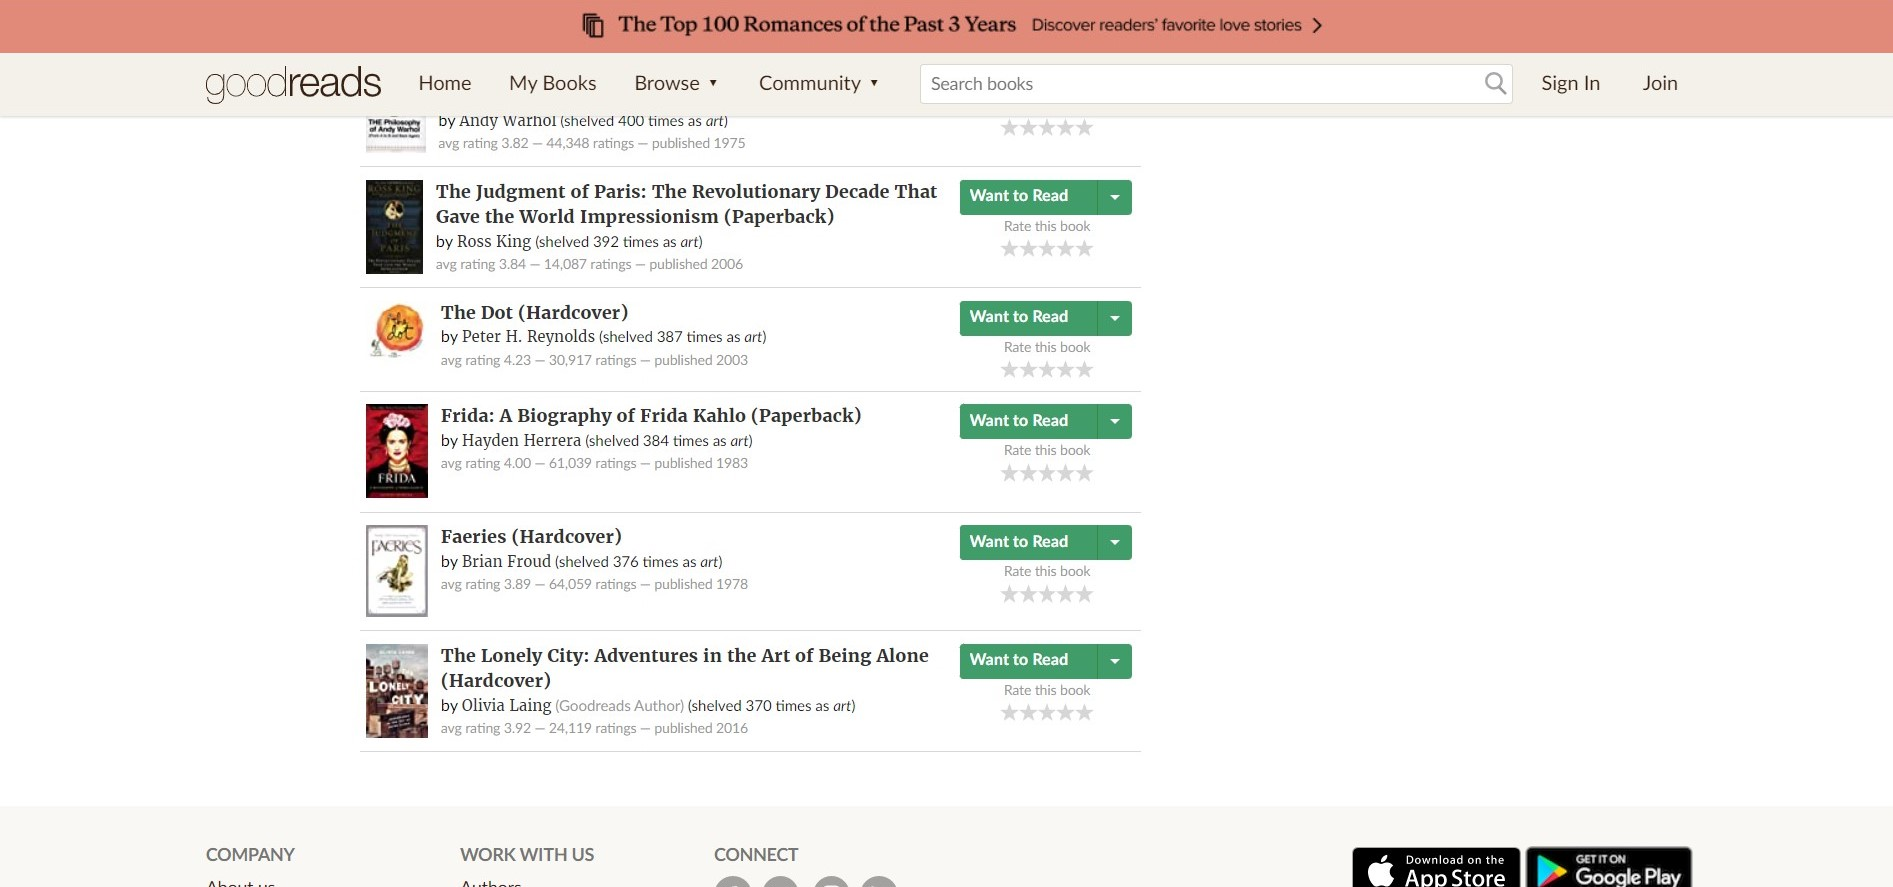

So we loged in :

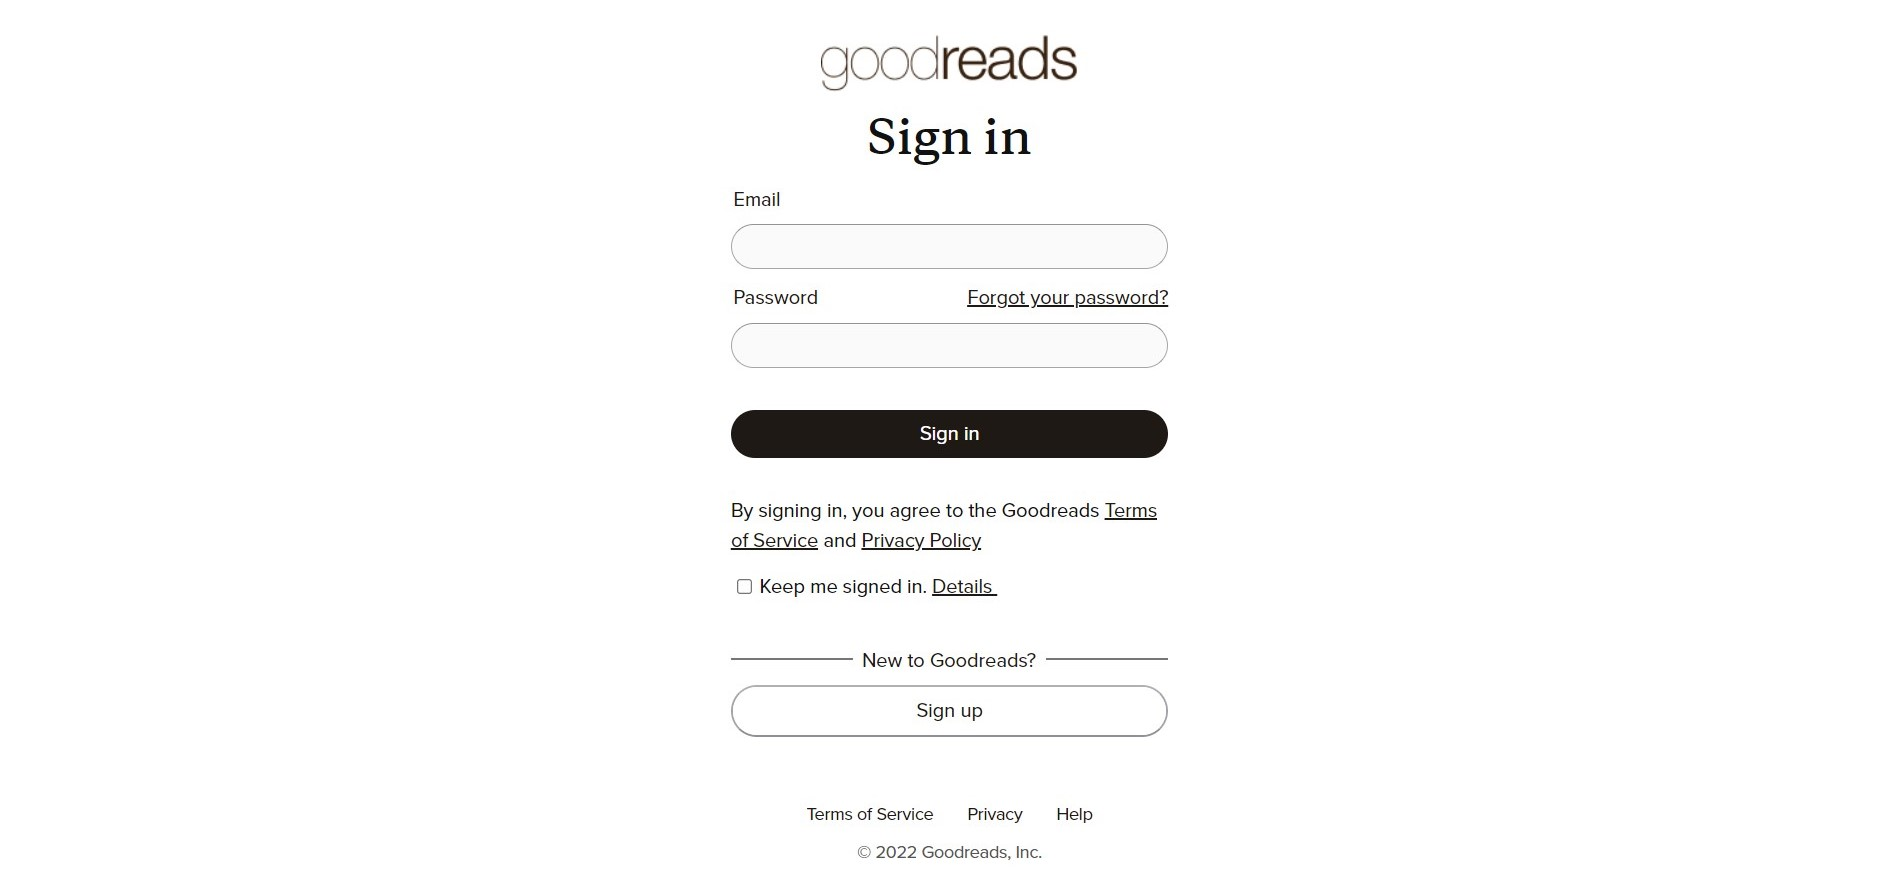

We then go through pages to get the link for each book int the genre :

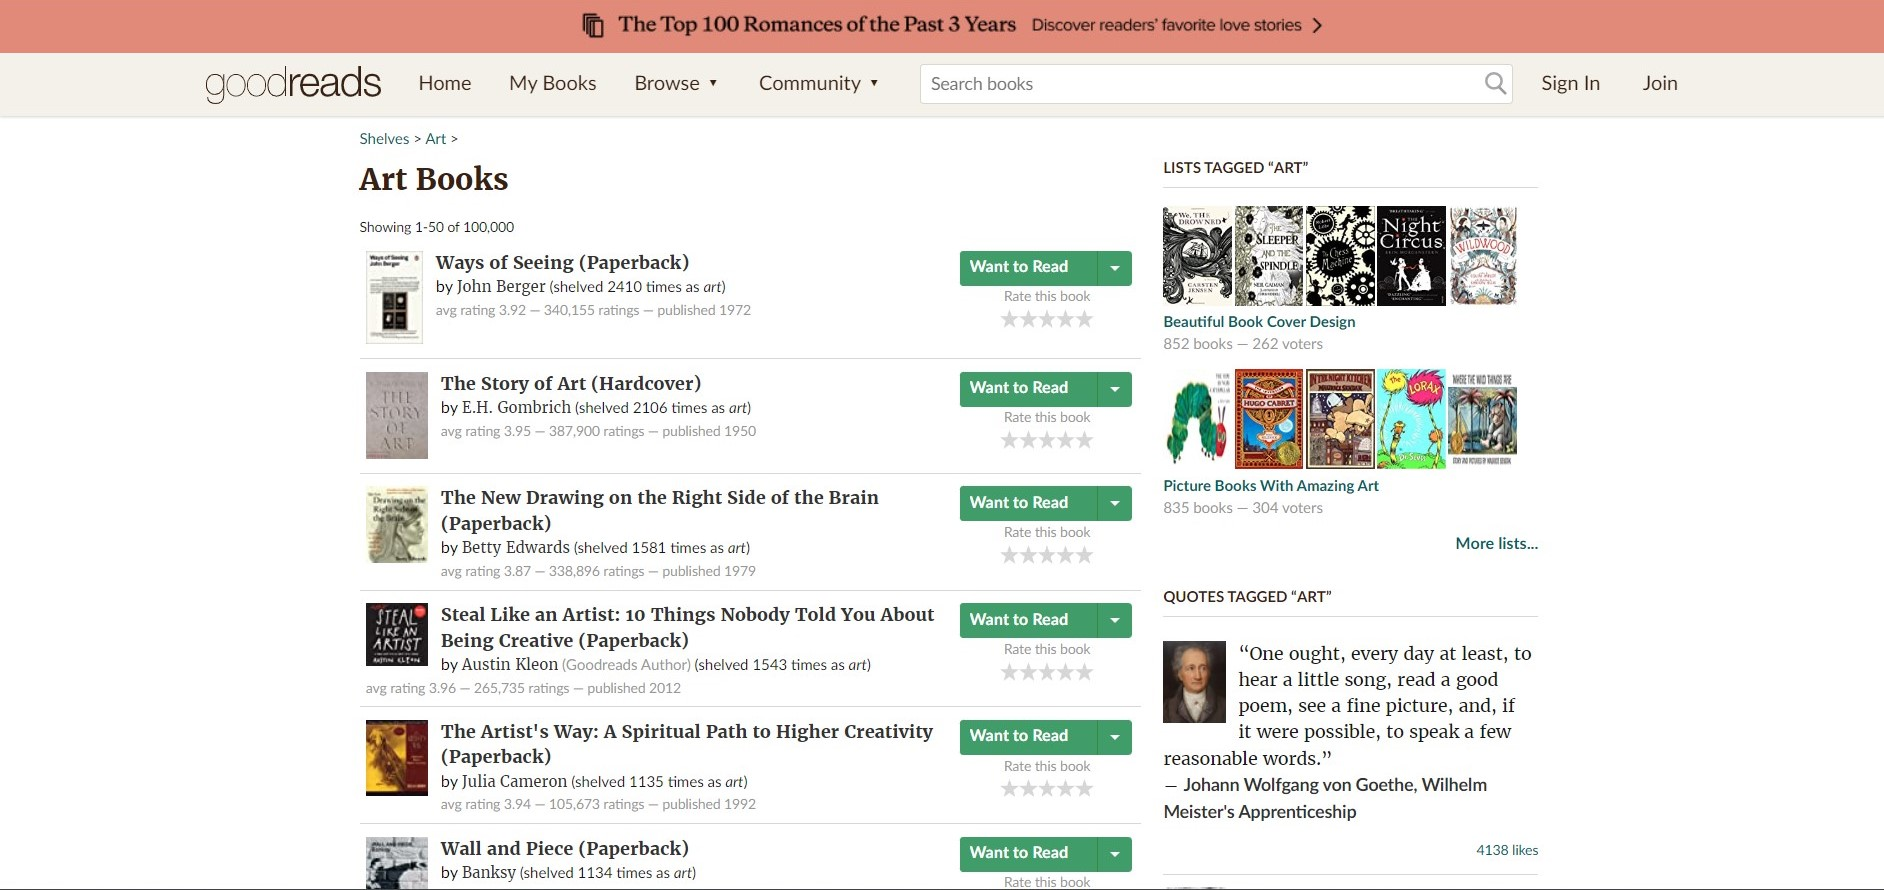

Than we go through the books using the links to scrape any wanted data about each book :

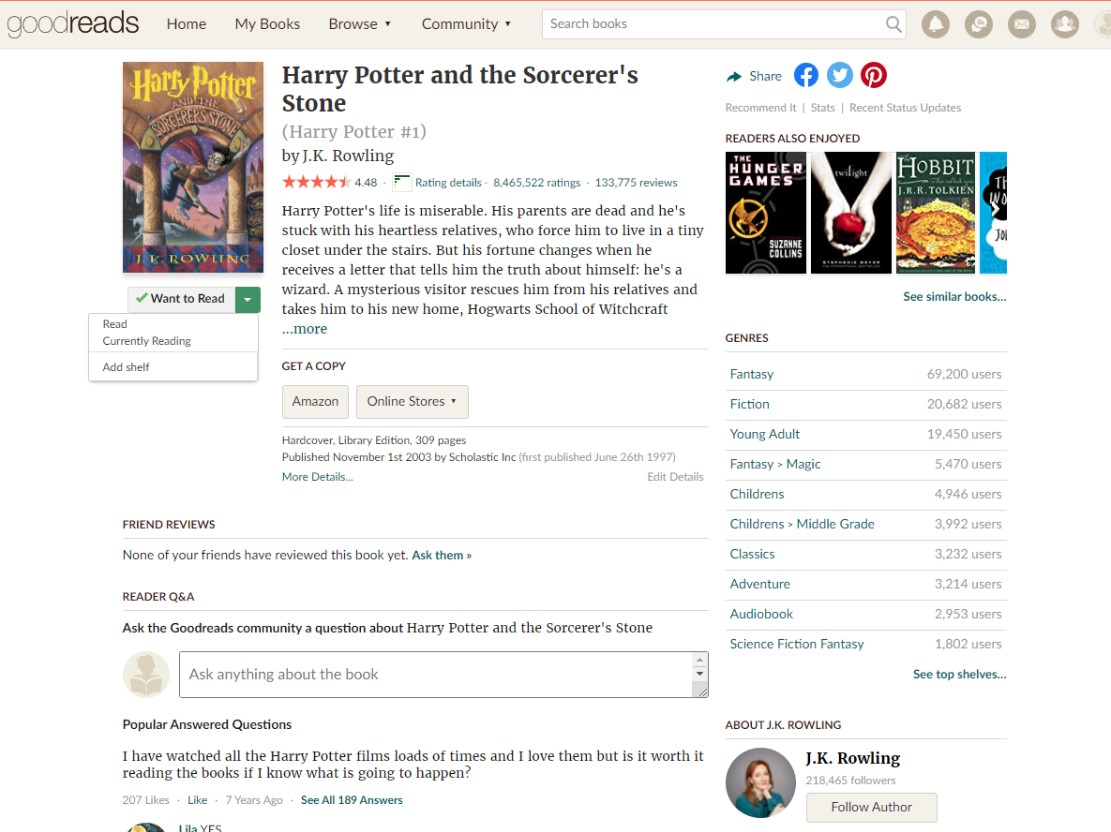

In [3]:
#to obtain the genres names
def get_genres():    
    genres_names = []
    
    #creating a driver and getting the site 
    driver = webdriver.Chrome()  
    driver.get("https://www.goodreads.com/") 
    
    #obtaining the genre names
    genres_box = driver.find_element(By.ID, "browseBox")
    genres_menu =genres_box.find_elements(By.CLASS_NAME , "left")
    
    for ea_left in genres_menu:
        elem = ea_left.find_elements(By.TAG_NAME,'a')
        
        for ea_elem in elem:
            genres_names.append(ea_elem.text)
        
    driver.quit()
    
    #remove not real genres 
    genres_names.remove('More genres')
    genres_names.remove('Ebooks')
    
    return genres_names



#obtaning the urls of the genres 
def Url_genres():  
    
    Url_str = 'https://www.goodreads.com/shelf/show/'
    list_genres = get_genres()
    url_dict = {}
    
    for ea_genres in list_genres:
        url_dict[ea_genres]=(Url_str + ea_genres)
    
    return url_dict




#signing in to a user
def log_in_func():
    
    s=Service("chromedriver.exe")
    opts=Options()
    opts.headless = True
    driver = webdriver.Chrome(service=s)
    
    #getting sign-in page
    driver.get("https://www.goodreads.com/ap/signin?language=en_US&openid.assoc_handle=amzn_goodreads_web_na&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.mode=checkid_setup&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.goodreads.com%2Fap-handler%2Fsign-in&siteState=7fc9c2e7144cbfcdc1c3e6b4d7e90662")
    
    #sending keys 
    driver.find_element("id", "ap_email").send_keys('talshamli34@gmail.com')
    driver.find_element("id", "ap_password").send_keys('Talshamli5511')
    driver.find_element("id", "signInSubmit").click()
    
    return driver
    

#get the urls of the books in each page    
def get_page_books(driver):  
    
    book_list = []
    try:
        books_link = driver.find_elements(By.CLASS_NAME, "bookTitle")
        
    except:
        pass
     
        
    for ea_book in books_link:
        try:
            book_list.append(ea_book.get_attribute("href"))
            
        except Exception as e:
            print(ea_book + " didnt have href")
            pass
        
    return book_list
            

# get all the urls of the books in a genre first 20 pages    
def get_books_urls():          
    
    dict_genere_url = Url_genres() #to obtain the genres names
    books_urls={} 
    list_of_all_urls_final = []
    
    #signing-in
    driver = log_in_func()
    
    #using the genre links to obtain books urls in each genre
    for key, link in dict_genere_url.items() :
        
        driver.get(link)
        books_urls[key] = []
        
        for page in range(1,21):
            #obtaining the ursl of all the books in a page
            books_urls[key] += (get_page_books(driver))
            
            #waiting for the 'next page' button to fully reload
            time.sleep(3)
            try:
                driver.find_element(By.CLASS_NAME,"next_page").click()
            except Exception as e:
                print("didnt find the next_page button")
                
                for i in range(1,4):
                    
                    driver.refresh()
                    try:
                        driver.find_element(By.CLASS_NAME,"next_page").click()
                    except Exception as e:
                        print("didnt find the next_page button")
            
                
    #saving the data    
    json.dump(books_urls,open("data/books_urls.json","w"))
    
    driver.quit()
    
    return books_urls

books_url_links = json.load(open("data/books_urls.json"))


#getting the data needed for each book
def get_books_data(books_url_links):
    
    #signing-in
    driver = log_in_func()
    print("start scraping")
    
    #using the links for each book to scrape the data
    for key, links in books_url_links.items():
        genre_list=[]
        print("start scraping " + key + " genre")
        
        for link in links:
            
            #getting in the book page
            driver.get(link)
            
            #waiting for the page to fully reaload  
            time.sleep(3)
            
            book_dict={}
            
            try:
                book_dict['title']=driver.find_element("id","bookTitle").text
            except:
                book_dict['title']=np.nan
            
            try:
                book_dict['rating']=driver.find_element(By.CSS_SELECTOR,'span[itemprop=ratingValue]').text
            except:
                book_dict['rating']=np.nan
            
            try:
                book_dict['num_ratings']=driver.find_element(By.ID,"bookMeta").find_element(By.CSS_SELECTOR,'meta[itemprop=ratingCount]').get_attribute('content')
            except:
                book_dict['num_ratings']=np.nan
            
            try:
                book_dict['num_reviews']=driver.find_element(By.ID,"bookMeta").find_element(By.CSS_SELECTOR,'meta[itemprop=reviewCount]').get_attribute('content')
            except:
                book_dict['num_reviews']=np.nan
            
            try:
                book_dict['num_awards']=len(driver.find_element(By.CSS_SELECTOR,'div[itemprop=awards]').find_elements(By.CLASS_NAME,"award"))
            except:
                book_dict['num_awards']=np.nan
                
            try:
                book_dict['language']=driver.find_element("id","bookDataBox").find_element(By.CSS_SELECTOR,'div[itemprop=inLanguage]').text
            except:
                book_dict['language']=np.nan
                
            try:
                book_dict['num_page']=driver.find_element("id","details").find_element(By.CSS_SELECTOR,'span[itemprop=numberOfPages]').text
            except:
                book_dict['num_page']=np.nan
                
            try:
                book_dict['cover_type']=driver.find_element("id","details").find_element(By.CSS_SELECTOR,'span[itemprop=bookFormat]').text
            except:
                book_dict['cover_type']=np.nan
            
            try:
                book_dict['published_year']=driver.find_element("id","details").find_elements(By.CLASS_NAME,"row")[1].text
            except:
                book_dict['published_year']=np.nan
            
            try:
                book_dict['genre']=driver.find_element(By.CLASS_NAME,"actionLinkLite.bookPageGenreLink").text
            except:
                book_dict['genre']=np.nan
                
            try:
                book_dict['author']=driver.find_element("id","bookAuthors").find_element(By.CSS_SELECTOR,'span[itemprop=name]').text
            except:
                book_dict['author']=np.nan
                
            
            genre_list.append(book_dict)
            
            
        
        print("done scraping " + key + " genre")
        df=pd.DataFrame(genre_list) # Creating Dataframe for each genre
        df.to_csv("data/"+ key +"_df.csv",index=False) # index = False so it wouldnt save index column per genre
        
    driver.quit()   
    print("done scraping")

    
#Combining all the genre dataframes into one    
def CSVs_to_DF(book_genres):
    
    df_list=[]
    
    for genre in book_genres:
        
        df_list.append(pd.read_csv(f'data/{genre}_df.csv',index_col=[0]))
        
    df=pd.concat(df_list,ignore_index=True)
    df.to_csv("data/goodreads_df.csv")
    
    return df

In [2]:
#droping an unnamed index column
    
df = pd.read_csv('data/Young Adult_df.csv') #change it to "data/goodreads_df.csv" after running the crawler again
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df



title  rating  num_ratings  \
0                                         Ways of Seeing    3.91     337779.0   
1                                       The Story of Art    3.95     386030.0   
2         The New Drawing on the Right Side of the Brain    3.87     337821.0   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96     263696.0   
4                                         Wall and Piece    3.85     221069.0   
...                                                  ...     ...          ...   
27829                                             Wicked    3.97      49210.0   
27830                                  Reason to Breathe    4.21      90914.0   
27831                                          Supernova    4.41      57736.0   
27832                                            Airhead    3.77      38246.0   
27833                                    Vanishing Girls    3.57      30586.0   

       num_reviews  num_awards language   num_page       cover_type  \
0           2301.0         2.0  English  176 pages        Paperback   
1           1268.0         NaN  English  688 pages        Hardcover   
2            935.0         NaN  English  291 pages        Paperback   
3           7934.0         1.0  English  160 pages        Paperback   
4            961.0         NaN  English  240 pages        Paperback   
...            ...         ...      ...        ...              ...   
27829       1835.0         NaN  English  312 pages  Library Binding   
27830       6234.0         1.0  English  377 pages   Kindle Edition   
27831       8575.0         1.0  English  549 pages        Hardcover   
27832       2189.0         NaN  English  337 pages        Hardcover   
27833       4332.0         NaN  English  357 pages        Hardcover   

                                          published_year        genre  \
0       Published 1990 by Penguin (first published 1972)          Art   
1      Published April 9th 1995 by Phaidon Press (fir...          Art   
2      Published August 30th 1999 by Tarcher (first p...          Art   
3      Published February 28th 2012 by Workman Publis...   Nonfiction   
4       Published 2006 by Century (first published 2005)          Art   
...                                                  ...          ...   
27829         Published November 25th 2008 by HarperTeen  Young Adult   
27830                            Published May 10th 2011      Romance   
27831    Published November 5th 2019 by Feiwel & Friends      Fantasy   
27832                   Published June 1st 2008 by Point  Young Adult   
27833         Published March 10th 2015 by HarperCollins  Young Adult   

                author  
0          John Berger  
1        E.H. Gombrich  
2        Betty Edwards  
3         Austin Kleon  
4               Banksy  
...                ...  
27829     Sara Shepard  
27830  Rebecca Donovan  
27831    Marissa Meyer  
27832        Meg Cabot  
27833    Lauren Oliver  

[27834 rows x 11 columns]

# Data handling

 **sources/credits:**
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
- https://stackoverflow.com/questions/43983622/remove-unnamed-columns-in-pandas-dataframe
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- https://docs.python.org/3/library/re.html

### Extracting numeric data

We need to extract numeric data form data scraped form GoodReads. 

To accomplish that we will use regular exprasion :

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27834 entries, 0 to 27833
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           27702 non-null  object 
 1   rating          27702 non-null  float64
 2   num_ratings     27702 non-null  float64
 3   num_reviews     27702 non-null  float64
 4   num_awards      12567 non-null  float64
 5   language        26182 non-null  object 
 6   num_page        27566 non-null  object 
 7   cover_type      27614 non-null  object 
 8   published_year  27689 non-null  object 
 9   genre           27701 non-null  object 
 10  author          27702 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.3+ MB


In [4]:
#extracting the number from the string and converting to int

df_cleaned = df.copy()

df_cleaned['published_year'] = df_cleaned['published_year'].str.findall('\d{4}').str[-1].astype('Int64')

df_cleaned['num_page'] = df_cleaned['num_page'].str.findall('\d+').str[0].astype('Int64')

df_cleaned['num_ratings'] = df_cleaned['num_ratings'].astype('Int64')

df_cleaned['num_reviews'] = df_cleaned['num_reviews'].astype('Int64')

df_cleaned

title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
27829                                             Wicked    3.97        49210   
27830                                  Reason to Breathe    4.21        90914   
27831                                          Supernova    4.41        57736   
27832                                            Airhead    3.77        38246   
27833                                    Vanishing Girls    3.57        30586   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301         2.0  English       176        Paperback   
1             1268         NaN  English       688        Hardcover   
2              935         NaN  English       291        Paperback   
3             7934         1.0  English       160        Paperback   
4              961         NaN  English       240        Paperback   
...            ...         ...      ...       ...              ...   
27829         1835         NaN  English       312  Library Binding   
27830         6234         1.0  English       377   Kindle Edition   
27831         8575         1.0  English       549        Hardcover   
27832         2189         NaN  English       337        Hardcover   
27833         4332         NaN  English       357        Hardcover   

       published_year        genre           author  
0                1972          Art      John Berger  
1                1950          Art    E.H. Gombrich  
2                1979          Art    Betty Edwards  
3                2012   Nonfiction     Austin Kleon  
4                2005          Art           Banksy  
...               ...          ...              ...  
27829            2008  Young Adult     Sara Shepard  
27830            2011      Romance  Rebecca Donovan  
27831            2019      Fantasy    Marissa Meyer  
27832            2008  Young Adult        Meg Cabot  
27833            2015  Young Adult    Lauren Oliver  

[27834 rows x 11 columns]

### Handeling missing values

In [5]:
#Droping any book theat dont have a rating

df_cleaned=df_cleaned.dropna(axis='index',subset='rating')

df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned

title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
27697                                             Wicked    3.97        49210   
27698                                  Reason to Breathe    4.21        90914   
27699                                          Supernova    4.41        57736   
27700                                            Airhead    3.77        38246   
27701                                    Vanishing Girls    3.57        30586   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301         2.0  English       176        Paperback   
1             1268         NaN  English       688        Hardcover   
2              935         NaN  English       291        Paperback   
3             7934         1.0  English       160        Paperback   
4              961         NaN  English       240        Paperback   
...            ...         ...      ...       ...              ...   
27697         1835         NaN  English       312  Library Binding   
27698         6234         1.0  English       377   Kindle Edition   
27699         8575         1.0  English       549        Hardcover   
27700         2189         NaN  English       337        Hardcover   
27701         4332         NaN  English       357        Hardcover   

       published_year        genre           author  
0                1972          Art      John Berger  
1                1950          Art    E.H. Gombrich  
2                1979          Art    Betty Edwards  
3                2012   Nonfiction     Austin Kleon  
4                2005          Art           Banksy  
...               ...          ...              ...  
27697            2008  Young Adult     Sara Shepard  
27698            2011      Romance  Rebecca Donovan  
27699            2019      Fantasy    Marissa Meyer  
27700            2008  Young Adult        Meg Cabot  
27701            2015  Young Adult    Lauren Oliver  

[27702 rows x 11 columns]

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27702 entries, 0 to 27701
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           27702 non-null  object 
 1   rating          27702 non-null  float64
 2   num_ratings     27702 non-null  Int64  
 3   num_reviews     27702 non-null  Int64  
 4   num_awards      12567 non-null  float64
 5   language        26182 non-null  object 
 6   num_page        27566 non-null  Int64  
 7   cover_type      27614 non-null  object 
 8   published_year  27683 non-null  Int64  
 9   genre           27701 non-null  object 
 10  author          27702 non-null  object 
dtypes: Int64(4), float64(2), object(5)
memory usage: 2.4+ MB


We can see in the dataframe that in the 'num_awards' column we have a lot of nan values, so we went back to GoodReads and foundout that book that didnt won any awardes didnt have any section saying that, so because of the way we scaped it was filled with nan values. We didnt want to loose valuable data so we filled the nan values in this column with 0 :

In [7]:
#we can see that one of the values is nan.

df['num_awards'].unique()

array([ 2., nan,  1.,  4.,  7.,  6.,  5.,  9., 14.,  3., 10., 13., 11.,
        8., 15., 12., 28., 22., 24., 18., 16., 21., 27., 17., 20., 41.,
       25., 29.])

In [8]:
#the book with no awards been filled as NaN, but its because they have no awards so we replaced the non values with 0.

df_cleaned['num_awards'] = df_cleaned['num_awards'].fillna(value=0).astype('Int64')

df_cleaned

C:\Users\mim47\AppData\Local\Temp\ipykernel_35220\3186836179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['num_awards'] = df_cleaned['num_awards'].fillna(value=0).astype('Int64')


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
27697                                             Wicked    3.97        49210   
27698                                  Reason to Breathe    4.21        90914   
27699                                          Supernova    4.41        57736   
27700                                            Airhead    3.77        38246   
27701                                    Vanishing Girls    3.57        30586   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
27697         1835           0  English       312  Library Binding   
27698         6234           1  English       377   Kindle Edition   
27699         8575           1  English       549        Hardcover   
27700         2189           0  English       337        Hardcover   
27701         4332           0  English       357        Hardcover   

       published_year        genre           author  
0                1972          Art      John Berger  
1                1950          Art    E.H. Gombrich  
2                1979          Art    Betty Edwards  
3                2012   Nonfiction     Austin Kleon  
4                2005          Art           Banksy  
...               ...          ...              ...  
27697            2008  Young Adult     Sara Shepard  
27698            2011      Romance  Rebecca Donovan  
27699            2019      Fantasy    Marissa Meyer  
27700            2008  Young Adult        Meg Cabot  
27701            2015  Young Adult    Lauren Oliver  

[27702 rows x 11 columns]

### Handeling duplications

In [9]:
#drop any "simple to recognize" duplicate

df_cleaned.drop_duplicates(inplace=True)

df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned

C:\Users\mim47\AppData\Local\Temp\ipykernel_35220\3514878117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(inplace=True)


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
24823                            Where the Sidewalk Ends    4.32      1322299   
24824                               A Conjuring of Light    4.33       131636   
24825                                             Wicked    3.97        49210   
24826                                          Supernova    4.41        57736   
24827                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
24823        11929           3  English       176        Hardcover   
24824        17385           3  English       624        Hardcover   
24825         1835           0  English       312  Library Binding   
24826         8575           1  English       549        Hardcover   
24827         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
24823            1974       Poetry  Shel Silverstein  
24824            2017      Fantasy       V.E. Schwab  
24825            2008  Young Adult      Sara Shepard  
24826            2019      Fantasy     Marissa Meyer  
24827            2008  Young Adult         Meg Cabot  

[24828 rows x 11 columns]

finding out if there are more subtle duplicates, that , for example have some minor changes like diffrence in the number of
poeple who rated the book (can happen if between times that the crawling procces has ancounterd the same book in diffrent 
genres) and someone rated the book in that gap, and etc, or even more importent, is if the crawling procces took more 
editions of the same book by mistake. so we tried to find some common things between book editions.

In [10]:
#checking the amount of duplicates by 'title' & 'author' columns

print(f"num of duplicates : {df_cleaned.duplicated(subset=['title','author']).sum()}")

num of duplicates : 5210


In [11]:
#checking the amount of duplicates by 'rating' & 'num_ratings' & 'author' columns

print(f"num of duplicates : {df_cleaned.duplicated(subset=['rating','num_ratings','author']).sum()}")

num of duplicates : 17


In [12]:
#droping duplicates by 'title' & 'author' columns

df_cleaned.drop_duplicates(subset = ['title','author'],inplace=True)

df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned

C:\Users\mim47\AppData\Local\Temp\ipykernel_35220\2344264001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(subset = ['title','author'],inplace=True)


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
19613                                        Sisters Red    3.63        19526   
19614                                       The Struggle    3.45        39614   
19615                                    Yes No Maybe So    3.76        23681   
19616                                             Wicked    3.97        49210   
19617                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
19613         2577           0  English       328        Hardcover   
19614         1642           0  English       278        Paperback   
19615         3922           1  English       464            ebook   
19616         1835           0  English       312  Library Binding   
19617         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
19613            2010      Fantasy    Jackson Pearce  
19614            1991  Young Adult        L.J. Smith  
19615            2020      Romance  Becky Albertalli  
19616            2008  Young Adult      Sara Shepard  
19617            2008  Young Adult         Meg Cabot  

[19618 rows x 11 columns]

In [13]:
#droping duplicates by 'rating' & 'num_ratings' & 'author' columns

df_cleaned.drop_duplicates(subset = ['rating','num_ratings','author'],inplace=True)

df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned

C:\Users\mim47\AppData\Local\Temp\ipykernel_35220\2754895430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(subset = ['rating','num_ratings','author'],inplace=True)


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
19613                                        Sisters Red    3.63        19526   
19614                                       The Struggle    3.45        39614   
19615                                    Yes No Maybe So    3.76        23681   
19616                                             Wicked    3.97        49210   
19617                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
19613         2577           0  English       328        Hardcover   
19614         1642           0  English       278        Paperback   
19615         3922           1  English       464            ebook   
19616         1835           0  English       312  Library Binding   
19617         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
19613            2010      Fantasy    Jackson Pearce  
19614            1991  Young Adult        L.J. Smith  
19615            2020      Romance  Becky Albertalli  
19616            2008  Young Adult      Sara Shepard  
19617            2008  Young Adult         Meg Cabot  

[19618 rows x 11 columns]

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19618 entries, 0 to 19617
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           19618 non-null  object 
 1   rating          19618 non-null  float64
 2   num_ratings     19618 non-null  Int64  
 3   num_reviews     19618 non-null  Int64  
 4   num_awards      19618 non-null  Int64  
 5   language        18286 non-null  object 
 6   num_page        19500 non-null  Int64  
 7   cover_type      19541 non-null  object 
 8   published_year  19599 non-null  Int64  
 9   genre           19617 non-null  object 
 10  author          19618 non-null  object 
dtypes: Int64(5), float64(1), object(5)
memory usage: 1.7+ MB


for all the rest columns we decided not to fill any Nan and drop it.

In [15]:
#drop any rows with NaN values 

df_cleaned.dropna(axis='index',how='any',inplace=True)

df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned

C:\Users\mim47\AppData\Local\Temp\ipykernel_35220\1500895517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(axis='index',how='any',inplace=True)


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
18152                                        Sisters Red    3.63        19526   
18153                                       The Struggle    3.45        39614   
18154                                    Yes No Maybe So    3.76        23681   
18155                                             Wicked    3.97        49210   
18156                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
18152         2577           0  English       328        Hardcover   
18153         1642           0  English       278        Paperback   
18154         3922           1  English       464            ebook   
18155         1835           0  English       312  Library Binding   
18156         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
18152            2010      Fantasy    Jackson Pearce  
18153            1991  Young Adult        L.J. Smith  
18154            2020      Romance  Becky Albertalli  
18155            2008  Young Adult      Sara Shepard  
18156            2008  Young Adult         Meg Cabot  

[18157 rows x 11 columns]

### Dealing with outliers

In [16]:
df_cleaned.describe()

rating   num_ratings    num_reviews    num_awards      num_page  \
count  18157.000000  1.815700e+04   18157.000000  18157.000000  18157.000000   
mean       4.038494  5.724361e+04    3408.512419      0.965688    331.440932   
std        0.239928  2.173033e+05    8818.565718      1.948155    219.104920   
min        2.730000  1.000000e+00       1.000000      0.000000      0.000000   
25%        3.890000  4.075000e+03     301.000000      0.000000    224.000000   
50%        4.050000  1.289100e+04     917.000000      0.000000    310.000000   
75%        4.200000  4.134500e+04    2956.000000      1.000000    400.000000   
max        5.000000  9.081188e+06  190330.000000     41.000000  14777.000000   

       published_year  
count    18157.000000  
mean      1994.965468  
std         50.663705  
min       1000.000000  
25%       1994.000000  
50%       2008.000000  
75%       2015.000000  
max       2023.000000

In [17]:
#outlier plot detection in the 'rating' column

fig = px.histogram(df_cleaned, x = 'rating')

fig.show()

In [18]:
#outlier plot detection in the 'rating' column

fig = px.box(df_cleaned, x='rating',orientation='h')

fig.show()

In [742]:
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

In [743]:
outliers = find_outliers_IQR(df_cleaned['rating'])

print('number of outliers:' + str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

outliers

number of outliers:249
max outlier value: 5.0
min outlier value: 2.73


275      3.35
379      4.71
564      5.00
650      4.68
664      4.69
         ... 
17810    3.26
17841    3.42
17850    3.35
17860    3.10
18010    3.36
Name: rating, Length: 249, dtype: float64

we can clearly see that the data is normaly distributed, so we will use the z-score method for dealing with outliers

In [744]:
#detecting outliers by z-score method

z_score = (df_cleaned["rating"] - df_cleaned["rating"].mean()) / df_cleaned["rating"].std()
outliers = abs(z_score) > 3
sum(outliers)

108

In [745]:
#droping outlires

df_cleaned.rating[outliers] = np.nan

df_cleaned.dropna(axis='index',how='any',inplace=True)

df_cleaned.reset_index(drop=True,inplace=True)

df_cleaned

C:\Users\mim47\AppData\Local\Temp\ipykernel_1928\1312531128.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mim47\AppData\Local\Temp\ipykernel_1928\1312531128.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
18044                                        Sisters Red    3.63        19526   
18045                                       The Struggle    3.45        39614   
18046                                    Yes No Maybe So    3.76        23681   
18047                                             Wicked    3.97        49210   
18048                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
18044         2577           0  English       328        Hardcover   
18045         1642           0  English       278        Paperback   
18046         3922           1  English       464            ebook   
18047         1835           0  English       312  Library Binding   
18048         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
18044            2010      Fantasy    Jackson Pearce  
18045            1991  Young Adult        L.J. Smith  
18046            2020      Romance  Becky Albertalli  
18047            2008  Young Adult      Sara Shepard  
18048            2008  Young Adult         Meg Cabot  

[18049 rows x 11 columns]

In [746]:
print('the information regarding the final dataframe:\n')

df_cleaned.info()

df_cleaned

the information regarding the final dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18049 entries, 0 to 18048
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           18049 non-null  object 
 1   rating          18049 non-null  float64
 2   num_ratings     18049 non-null  Int64  
 3   num_reviews     18049 non-null  Int64  
 4   num_awards      18049 non-null  Int64  
 5   language        18049 non-null  object 
 6   num_page        18049 non-null  Int64  
 7   cover_type      18049 non-null  object 
 8   published_year  18049 non-null  Int64  
 9   genre           18049 non-null  object 
 10  author          18049 non-null  object 
dtypes: Int64(5), float64(1), object(5)
memory usage: 1.6+ MB


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
18044                                        Sisters Red    3.63        19526   
18045                                       The Struggle    3.45        39614   
18046                                    Yes No Maybe So    3.76        23681   
18047                                             Wicked    3.97        49210   
18048                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
18044         2577           0  English       328        Hardcover   
18045         1642           0  English       278        Paperback   
18046         3922           1  English       464            ebook   
18047         1835           0  English       312  Library Binding   
18048         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
18044            2010      Fantasy    Jackson Pearce  
18045            1991  Young Adult        L.J. Smith  
18046            2020      Romance  Becky Albertalli  
18047            2008  Young Adult      Sara Shepard  
18048            2008  Young Adult         Meg Cabot  

[18049 rows x 11 columns]

# EDA

 **sources/credits:**
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://seaborn.pydata.org/tutorial/color_palettes.html
- https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/subplots_demo.html
- https://plotly.com/python/histograms/

### Corolation matrix

Lets look at the corrolation between the numeric columns :

<AxesSubplot:>

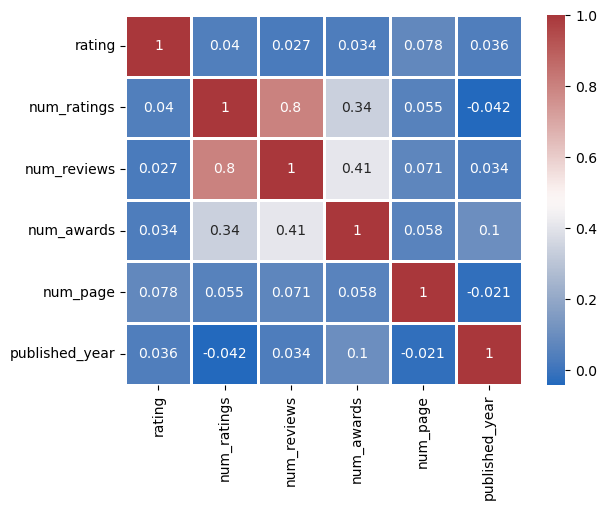

In [747]:
sns.heatmap(df_cleaned.corr(), annot=True,cmap="vlag",linewidths=1)

We can see that the 'rating' column dont corrolate to a specific column.

### Ploting categorical columns
Now, lets look at the value counts for each of the categorial columns :

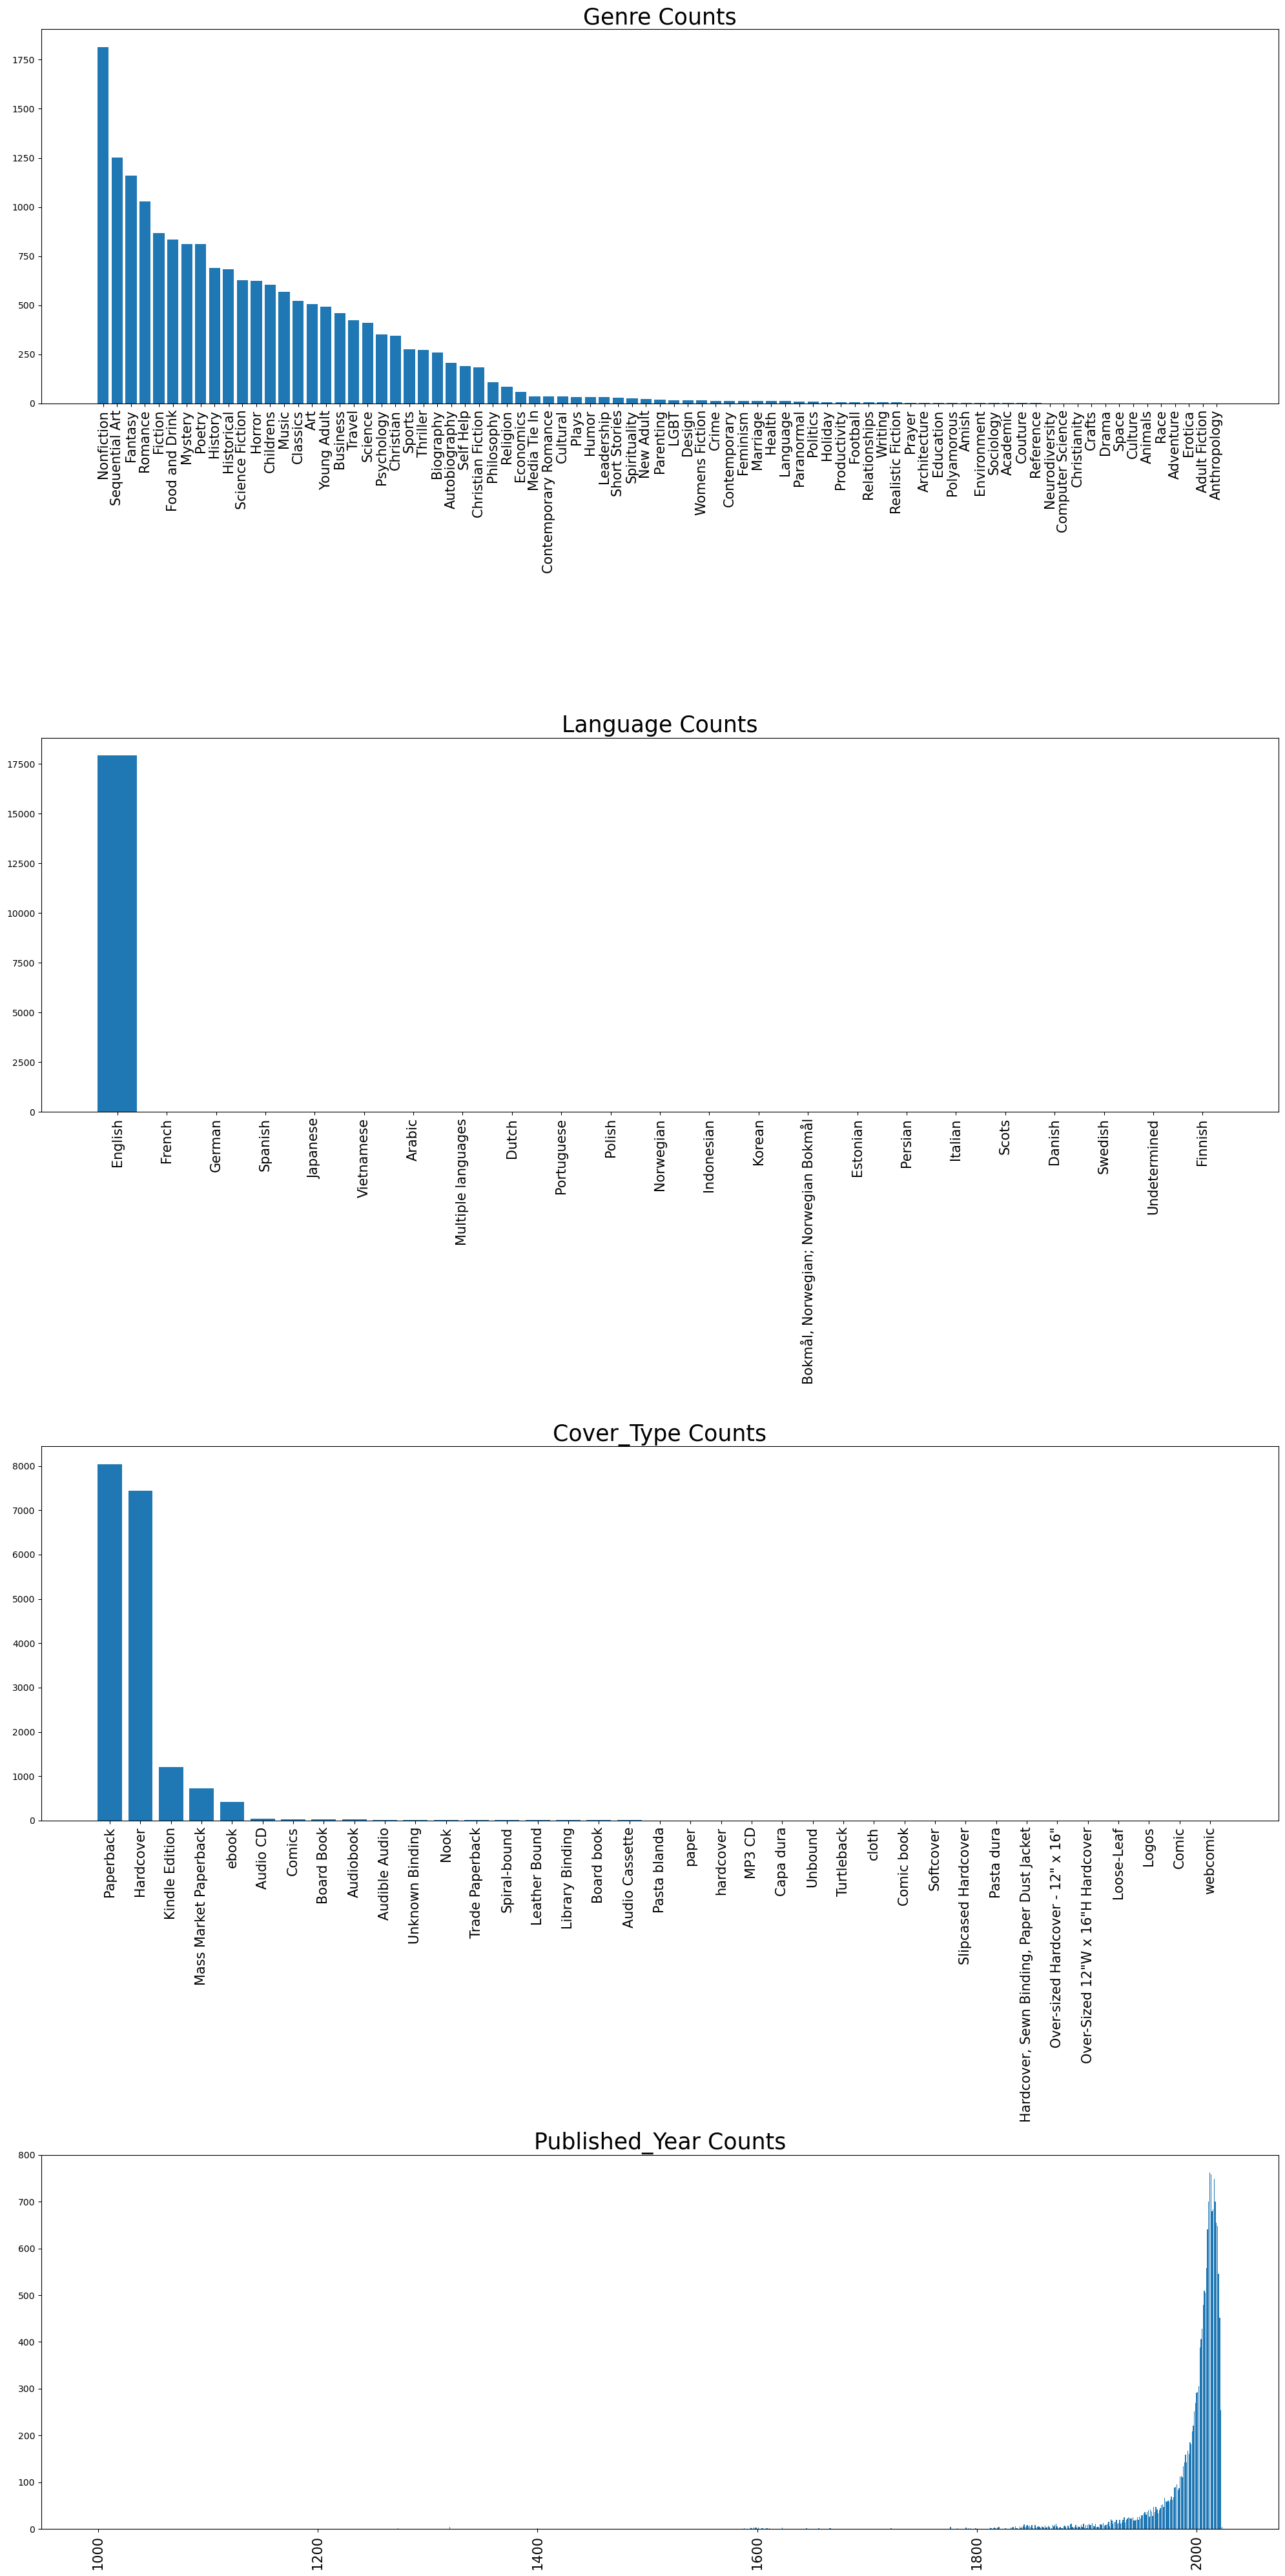

In [748]:
cols = ['genre','language','cover_type','published_year']

fig, ax = plt.subplots(4,1,figsize=(20,40))

for i,col in enumerate(cols):
    
    series = df_cleaned.groupby(df_cleaned[col]).count()['title'].sort_values(ascending=False)

    ax[i].bar(series.index,series)
    ax[i].set_title(col.title()+" Counts",fontsize=25)
    ax[i].tick_params(labelrotation=90,axis='x',labelsize=15)
    ax[i].set(xlabel=None,ylabel=None)
    
plt.tight_layout()
   
plt.show()


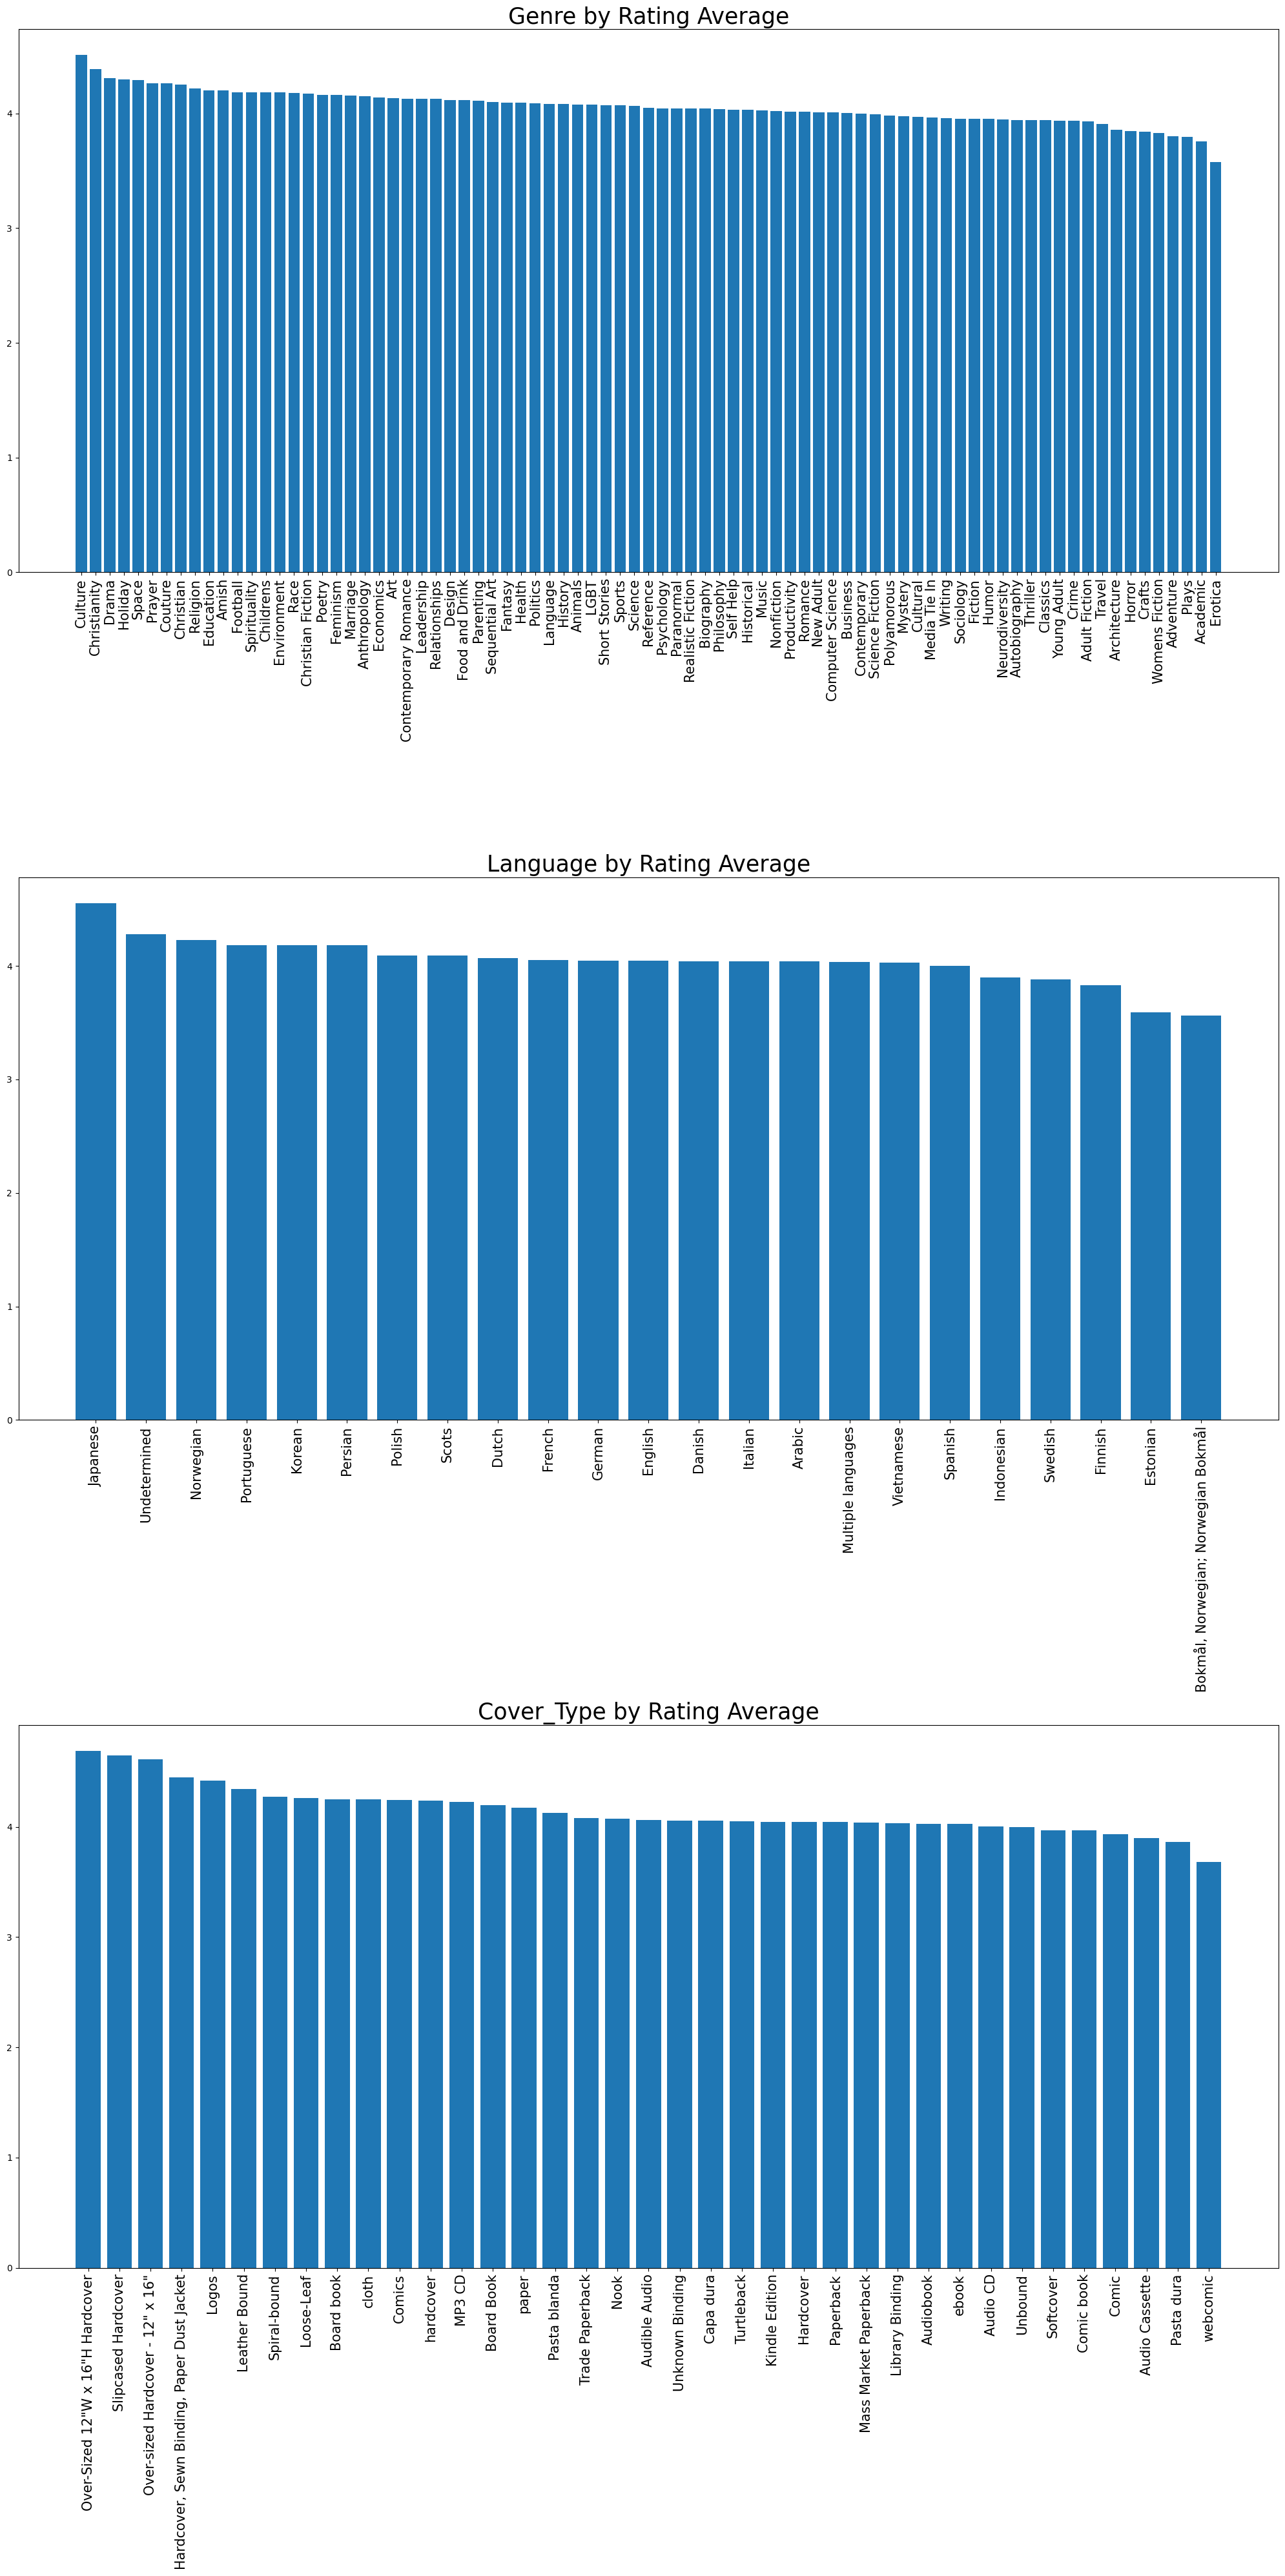

In [749]:
cols = ['genre','language','cover_type']

fig, ax = plt.subplots(3,1,figsize=(20,40))

for i,col in enumerate(cols):
    
    series = df_cleaned.groupby(df_cleaned[col])['rating'].mean().sort_values(ascending=False)

    ax[i].bar(series.index,series)
    ax[i].set_title(col.title()+" by Rating Average", fontsize=25)
    ax[i].tick_params(labelrotation=90, axis='x', labelsize=15)
    ax[i].set(xlabel=None,ylabel=None)
    
plt.tight_layout()
   
plt.show()


### Ploting numeric columns

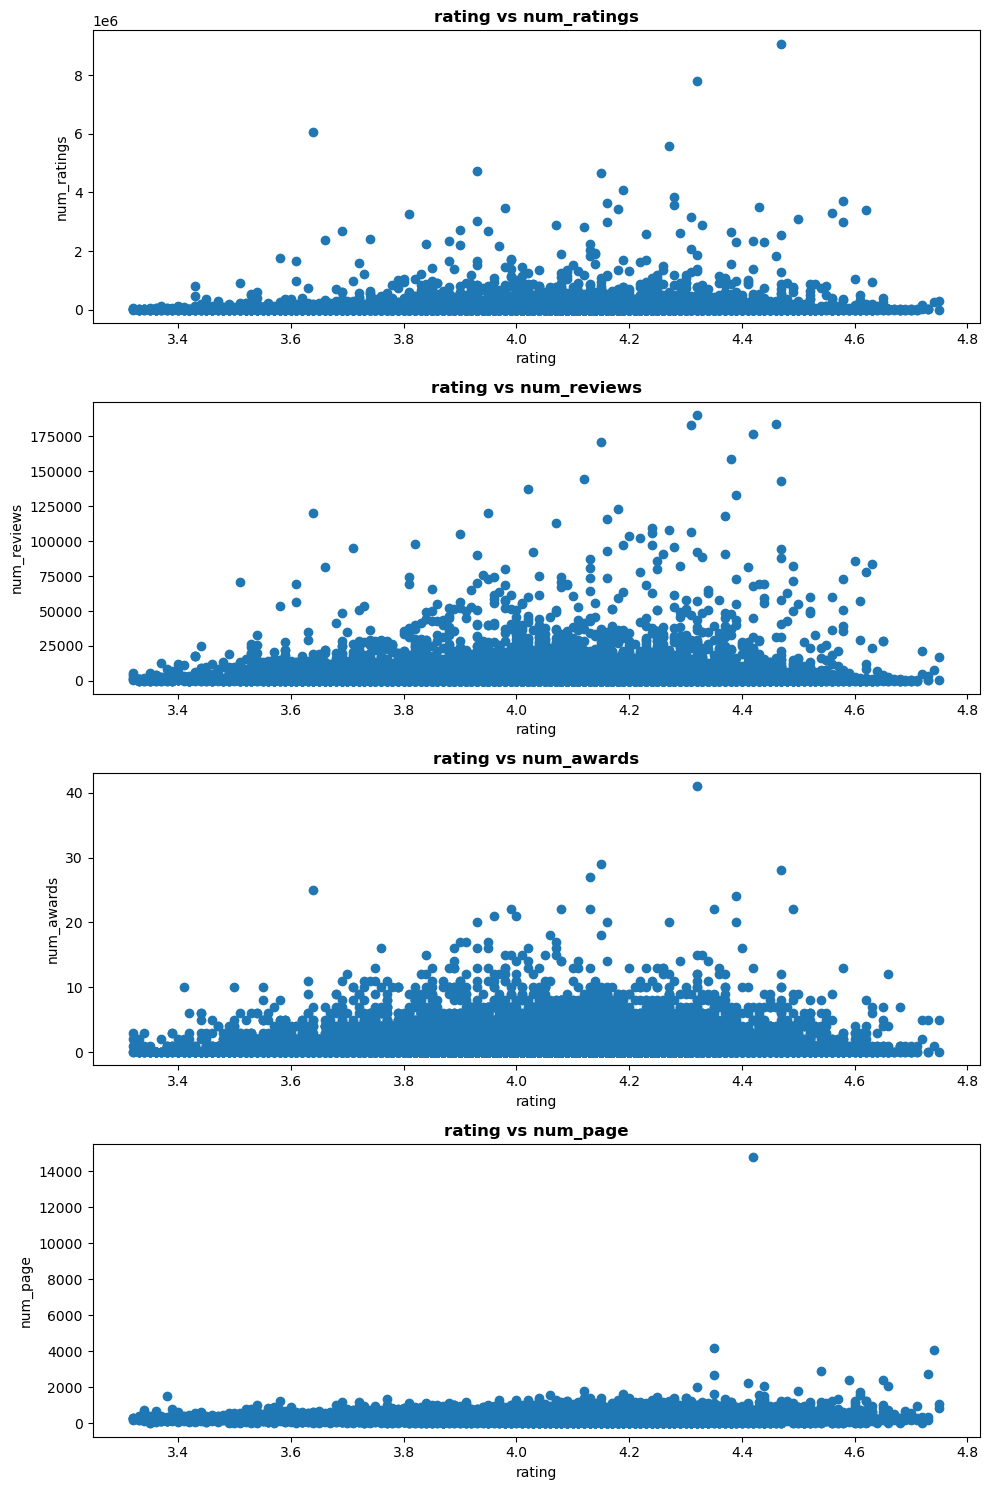

In [752]:
cols = ['num_ratings', 'num_reviews', 'num_awards','num_page']

fig,ax = plt.subplots(4, 1, figsize = (10,15))

for i, col in enumerate(cols):
    
    ax[i].scatter(df_cleaned['rating'], df_cleaned[col])
    ax[i].set_title('rating vs ' + col, fontweight = 'bold')
    ax[i].set_xlabel('rating')
    ax[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# Machine Learning 

After all the data exploration and visualization, we have a basic idea of what we want to look at so we could answer the quastion:
is it possible to predict the rating of a book ?

We will try to answer this buy bulding a Machine Learning moudle to try and do just that.
We chose the Linear Regression moudle beacuse :

 - The variable of 'rating' column is a continuous variable.
 - Very simple and intuitive.
 

Before that we need to do some extra work on our data : some of columns may not help us, the way they are now or at all.
So a little more work is needed.


### Pre-Processesing

In [794]:
df_cleaned.info()
df_cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18049 entries, 0 to 18048
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           18049 non-null  object 
 1   rating          18049 non-null  float64
 2   num_ratings     18049 non-null  Int64  
 3   num_reviews     18049 non-null  Int64  
 4   num_awards      18049 non-null  Int64  
 5   language        18049 non-null  object 
 6   num_page        18049 non-null  Int64  
 7   cover_type      18049 non-null  object 
 8   published_year  18049 non-null  Int64  
 9   genre           18049 non-null  object 
 10  author          18049 non-null  object 
dtypes: Int64(5), float64(1), object(5)
memory usage: 1.6+ MB


title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
18044                                        Sisters Red    3.63        19526   
18045                                       The Struggle    3.45        39614   
18046                                    Yes No Maybe So    3.76        23681   
18047                                             Wicked    3.97        49210   
18048                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page       cover_type  \
0             2301           2  English       176        Paperback   
1             1268           0  English       688        Hardcover   
2              935           0  English       291        Paperback   
3             7934           1  English       160        Paperback   
4              961           0  English       240        Paperback   
...            ...         ...      ...       ...              ...   
18044         2577           0  English       328        Hardcover   
18045         1642           0  English       278        Paperback   
18046         3922           1  English       464            ebook   
18047         1835           0  English       312  Library Binding   
18048         2189           0  English       337        Hardcover   

       published_year        genre            author  
0                1972          Art       John Berger  
1                1950          Art     E.H. Gombrich  
2                1979          Art     Betty Edwards  
3                2012   Nonfiction      Austin Kleon  
4                2005          Art            Banksy  
...               ...          ...               ...  
18044            2010      Fantasy    Jackson Pearce  
18045            1991  Young Adult        L.J. Smith  
18046            2020      Romance  Becky Albertalli  
18047            2008  Young Adult      Sara Shepard  
18048            2008  Young Adult         Meg Cabot  

[18049 rows x 11 columns]

In [754]:
#spliting the data into train and test sets, and spliting the test set further in to evaluation set and train set so we 
#would have more data to test on

X = df_cleaned.drop(['rating','title'],axis=1)
y = df_cleaned['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)

In [755]:
#transform columns from categorial to binery categorial column

cols =['cover_type', 'genre', 'language']

df_dummies = pd.get_dummies(X[cols])

X_train_dummies = df_dummies.loc[X_train.index,:]
X_test_dummies = df_dummies.loc[X_test.index,:]
X_val_dummies = df_dummies.loc[X_val.index,:]

In [756]:
#scaling the numeric columns

scaler = MinMaxScaler()

cols = X.select_dtypes(include =['float64','Int64']).columns

X_train_numeric_scaled = scaler.fit_transform(X_train[cols])
X_test_numeric_scaled = scaler.fit_transform(X_test[cols])
X_val_numeric_scaled = scaler.fit_transform(X_val[cols])

#transform it into dataframe
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled, columns = cols, index = X_train.index)
X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns = cols, index = X_test.index)
X_val_numeric_scaled = pd.DataFrame(X_val_numeric_scaled, columns = cols, index = X_val.index)

In [757]:
#combining the dummies dataframe and scaled dataframe into one for the model to work on

X_train_concat = pd.concat((X_train_numeric_scaled, X_train_dummies), axis=1)
X_test_concat = pd.concat((X_test_numeric_scaled, X_test_dummies), axis=1)
X_val_concat = pd.concat((X_val_numeric_scaled, X_val_dummies), axis=1)

In [758]:
#condacting PCA

pca = PCA(0.9)

X_train_PCA = pca.fit_transform(X_train_concat)
X_test_PCA = pca.transform(X_test_concat)
X_val_PCA = pca.transform(X_val_concat)

### First model
So, now its the time to finaly build and try our first model !!!

Lets try the model we chose at the beginning, the Linear Regression model :

In [709]:
Linear = LinearRegression()

Linear.fit(X_train_PCA, y_train)

prediction_Linear = Linear.predict(X_val_PCA)

print(f"R2 Score of Linear Regression : {r2_score(y_val, prediction_Linear)}")

R2 Score of Linear Regression : 0.09542733174216211


The R2 score is not that great...

Lets see if other Regressors can yield better resultes :

In [712]:
#SVR 

SVR = svm.SVR()

SVR.fit(X_train_PCA, y_train)

prediction_SVR = SVR.predict(X_val_PCA)

print(f"R2 Score of SVR : {r2_score(y_val, prediction_SVR)}")

R2 Score of SVR : 0.11783019089867741


In [713]:
#K Neighbors Regressor

knn = KNeighborsRegressor()

knn.fit(X_train_PCA, y_train)

prediction_knn = knn.predict(X_val_PCA)

print(f"R2 Score of K Neighbors Regressor : {r2_score(y_val, prediction_knn)}")

R2 Score of K Neighbors Regressor : 0.056922249018695026


In [714]:
#trying onther parametter

knn = KNeighborsRegressor(n_neighbors = 10)

knn.fit(X_train_PCA, y_train)

prediction_knn = knn.predict(X_val_PCA)

print(f"R2 Score of SVR : {r2_score(y_val, prediction_knn)}")

R2 Score of SVR : 0.14180429226949876


In [715]:
#Grid search to find the besst hyperparameter n_neighbors

knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [x for x in range(1,50)]}
    
grid = GridSearchCV(knn, parameters, scoring = 'r2')
    
        
grid.fit(X_train_PCA, y_train)
    
best_K = grid.best_params_['n_neighbors']
best_r2_val = grid.best_score_

In [716]:
print(f"Best k : {best_K}")
print(f"Best R2 Score : {best_r2_val}")

Best k : 20
Best R2 Score : 0.1807421562272648


Not great R2 scores.
Baybe if we can manipulate the data further we maybe able to improve our scores.

### Feature Engineering



Lets take a look at the 'cover_type' column :

In [603]:
df_cleaned['cover_type'].unique()

array(['Paperback', 'Hardcover', 'Mass Market Paperback',
       'Kindle Edition', 'Capa dura', 'Spiral-bound', 'ebook',
       'Turtleback', 'Over-sized Hardcover - 12" x 16"', 'Board Book',
       'Unknown Binding', 'Softcover', 'Over-Sized 12"W x 16"H Hardcover',
       'Audiobook', 'Audio CD', 'Audible Audio', 'Nook', 'Pasta dura',
       'hardcover', 'Board book', 'Library Binding', 'Leather Bound',
       'Trade Paperback', 'Logos', 'Comics', 'Slipcased Hardcover',
       'Comic', 'Pasta blanda', 'Loose-Leaf', 'Unbound', 'Audio Cassette',
       'webcomic', 'Comic book', 'MP3 CD', 'paper',
       'Hardcover, Sewn Binding, Paper Dust Jacket', 'cloth'],
      dtype=object)

We can see that the 'cover_type' column is to widely spread between values that if you look close (and use some google) you can see that most of the values are the same and can be recategorized as 5 categories - 'Hardcover', 'Softcover', 'Ebook', 'Audiobook', 'Unknown Binding'. 

so lets try and address this issue:

In [822]:
# recategorized the 'cover_type' column

hard_cover = ['Hardcover', 'Over-sized Hardcover - 12" x 16"', 'Over-Sized 12"W x 16"H Hardcover', 'hardcover', 'Capa dura',
            'Slipcased Hardcover','Hardcover, Sewn Binding, Paper Dust Jacket', 'Pasta dura',  'Leather Bound', 'Turtleback',
              'Board Book', 'Board book', 'Leather Bound', 'Library Binding','cloth']

soft_cover = ['Paperback','Mass Market Paperback','Softcover', 'Trade Paperback', 'Comics', 'Logos', 'Comic', 'Comic book',
              'paper', 'Pasta blanda', 'Loose-Leaf', 'Unbound', 'Spiral-bound']

ebook = ['Kindle Edition','Nook', 'webcomic', 'ebook']

audio_book = ['MP3 CD', 'Audiobook', 'Audio CD', 'Audible Audio', 'Audio Cassette']

df_enginered = df_cleaned.copy()

df_enginered.loc[df_enginered['cover_type'].isin(hard_cover), 'cover_type'] = 'Hardcover'

df_enginered.loc[df_enginered['cover_type'].isin(soft_cover), 'cover_type'] = 'Softcover' 

df_enginered.loc[df_enginered['cover_type'].isin(ebook), 'cover_type'] = 'Ebook' 

df_enginered.loc[df_enginered['cover_type'].isin(audio_book), 'cover_type'] = 'Audiobook' 



print(f'the new categories for "cover_type" column : ')
print(df_enginered['cover_type'].unique())

print("\n")

df_enginered


the new categories for "cover_type" column : 
['Softcover' 'Hardcover' 'Ebook' 'Unknown Binding' 'Audiobook']




title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
18044                                        Sisters Red    3.63        19526   
18045                                       The Struggle    3.45        39614   
18046                                    Yes No Maybe So    3.76        23681   
18047                                             Wicked    3.97        49210   
18048                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page cover_type  published_year  \
0             2301           2  English       176  Softcover            1972   
1             1268           0  English       688  Hardcover            1950   
2              935           0  English       291  Softcover            1979   
3             7934           1  English       160  Softcover            2012   
4              961           0  English       240  Softcover            2005   
...            ...         ...      ...       ...        ...             ...   
18044         2577           0  English       328  Hardcover            2010   
18045         1642           0  English       278  Softcover            1991   
18046         3922           1  English       464      Ebook            2020   
18047         1835           0  English       312  Hardcover            2008   
18048         2189           0  English       337  Hardcover            2008   

             genre            author  
0              Art       John Berger  
1              Art     E.H. Gombrich  
2              Art     Betty Edwards  
3       Nonfiction      Austin Kleon  
4              Art            Banksy  
...            ...               ...  
18044      Fantasy    Jackson Pearce  
18045  Young Adult        L.J. Smith  
18046      Romance  Becky Albertalli  
18047  Young Adult      Sara Shepard  
18048  Young Adult         Meg Cabot  

[18049 rows x 11 columns]

In [823]:
df['was_republished'] = (df['published_year'].str.contains('first') == True).astype('Int64')

df_enginered = pd.merge(df_enginered, df[['title', 'was_republished']], how = 'inner', on = 'title')

df_enginered.drop_duplicates(subset = ['title','author'], inplace = True)
df_enginered.reset_index(drop=True,inplace=True)

df_enginered

title  rating  num_ratings  \
0                                         Ways of Seeing    3.91       337779   
1                                       The Story of Art    3.95       386030   
2         The New Drawing on the Right Side of the Brain    3.87       337821   
3      Steal Like an Artist: 10 Things Nobody Told Yo...    3.96       263696   
4                                         Wall and Piece    3.85       221069   
...                                                  ...     ...          ...   
18044                                        Sisters Red    3.63        19526   
18045                                       The Struggle    3.45        39614   
18046                                    Yes No Maybe So    3.76        23681   
18047                                             Wicked    3.97        49210   
18048                                            Airhead    3.77        38246   

       num_reviews  num_awards language  num_page cover_type  published_year  \
0             2301           2  English       176  Softcover            1972   
1             1268           0  English       688  Hardcover            1950   
2              935           0  English       291  Softcover            1979   
3             7934           1  English       160  Softcover            2012   
4              961           0  English       240  Softcover            2005   
...            ...         ...      ...       ...        ...             ...   
18044         2577           0  English       328  Hardcover            2010   
18045         1642           0  English       278  Softcover            1991   
18046         3922           1  English       464      Ebook            2020   
18047         1835           0  English       312  Hardcover            2008   
18048         2189           0  English       337  Hardcover            2008   

             genre            author  was_republished  
0              Art       John Berger                1  
1              Art     E.H. Gombrich                1  
2              Art     Betty Edwards                1  
3       Nonfiction      Austin Kleon                0  
4              Art            Banksy                1  
...            ...               ...              ...  
18044      Fantasy    Jackson Pearce                0  
18045  Young Adult        L.J. Smith                1  
18046      Romance  Becky Albertalli                0  
18047  Young Adult      Sara Shepard                0  
18048  Young Adult         Meg Cabot                0  

[18049 rows x 12 columns]

### Second model
Now, lets try the models again :

In [810]:
#spliting the data into train and test sets, and spliting the test set further in to evaluation set and train set so we 
#would have more data to test on

X = df_cleaned.drop(['rating', 'title'],axis=1)
y = df_cleaned['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)

In [811]:
#transform columns from categorial to binery categorial column

cols =['cover_type', 'genre', 'language']

df_dummies = pd.get_dummies(X[cols])

X_train_dummies = df_dummies.loc[X_train.index,:]
X_test_dummies = df_dummies.loc[X_test.index,:]
X_val_dummies = df_dummies.loc[X_val.index,:]

In [812]:
#scaling the numeric columns

scaler = MinMaxScaler()

cols = X.select_dtypes(include =['float64','Int64']).columns

X_train_numeric_scaled = scaler.fit_transform(X_train[cols])
X_test_numeric_scaled = scaler.fit_transform(X_test[cols])
X_val_numeric_scaled = scaler.fit_transform(X_val[cols])

#transform it into dataframe
X_train_numeric_scaled = pd.DataFrame(X_train_numeric_scaled, columns = cols, index = X_train.index)
X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns = cols, index = X_test.index)
X_val_numeric_scaled = pd.DataFrame(X_val_numeric_scaled, columns = cols, index = X_val.index)

In [813]:
#combining the dummies dataframe and scaled dataframe into one for the model to work on

X_train_concat = pd.concat((X_train_numeric_scaled, X_train_dummies), axis=1)
X_test_concat = pd.concat((X_test_numeric_scaled, X_test_dummies), axis=1)
X_val_concat = pd.concat((X_val_numeric_scaled, X_val_dummies), axis=1)

In [814]:
#condacting PCA

pca = PCA(0.9)

X_train_PCA = pca.fit_transform(X_train_concat)
X_test_PCA = pca.transform(X_test_concat)
X_val_PCA = pca.transform(X_val_concat)

In [815]:
Linear = LinearRegression()

Linear.fit(X_train_PCA, y_train)

prediction_Linear = Linear.predict(X_val_PCA)

print(f"R2 Score of Linear Regression : {r2_score(y_val, prediction_Linear)}")

R2 Score of Linear Regression : 0.09542733174216211


In [816]:
#SVR 

SVR = svm.SVR()

SVR.fit(X_train_PCA, y_train)

prediction_SVR = SVR.predict(X_val_PCA)

print(f"R2 Score of SVR : {r2_score(y_val, prediction_SVR)}")

R2 Score of SVR : 0.11783019089867741


In [817]:
#K Neighbors Regressor

knn = KNeighborsRegressor()

knn.fit(X_train_PCA, y_train)

prediction_knn = knn.predict(X_val_PCA)

print(f"R2 Score of K Neighbors Regressor : {r2_score(y_val, prediction_knn)}")

R2 Score of K Neighbors Regressor : 0.056922249018695026


In [844]:
#trying onther parametter

knn = KNeighborsRegressor(n_neighbors = 10)

knn.fit(X_train_PCA, y_train)

prediction_knn = knn.predict(X_val_PCA)

print(f"R2 Score of K Neighbors Regressor : {r2_score(y_val, prediction_knn)}")

R2 Score of K Neighbors Regressor : 0.14180429226949876


In [825]:
#Grid search to find the besst hyperparameter n_neighbors

knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [x for x in range(1,50)], 'weights' : ['uniform', 'distance']}
    
grid = GridSearchCV(knn, parameters, cv = 10, scoring = 'r2')
    
        
grid.fit(X_train_PCA, y_train)
    
best = grid.best_params_
best_r2_val = grid.best_score_

In [826]:
print(f"Best k : {best}")
print(f"Best R2 Score : {best_r2_val}")

Best k : {'n_neighbors': 35, 'weights': 'distance'}
Best R2 Score : 0.20075213028412425


# Final Test

After all the tries, we will use the model that yeilded the best R2 score, the K Neighbors Regressor, with the best parameters we found using GridSearch :

In [827]:
knn = KNeighborsRegressor(n_neighbors = 35, weights = 'distance')

knn.fit(X_train_PCA, y_train)

prediction_knn = knn.predict(X_test_PCA)

print(f"R2 Score of SVR : {r2_score(y_test, prediction_knn)}")

R2 Score of SVR : 0.11168363643958623


# Conclusions

After we reaserched the data, cleaned the data, manipulated the data and used Machine Learning models, we concluded :
its not possible to predict the rating of a book based on the data we have.